# Chapter10 - LSTM Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

In [2]:
import matplotlib
from matplotlib import rc
font = {'size'   : 16}
matplotlib.rc('font', **font)

In [3]:
df = pd.read_csv("dataset_demand_forecasting_sd.csv")
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


### Timeseries Based

In [4]:
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


In [5]:
len(df)

2547

In [6]:
df['Sales'] = df["Sales"].rolling(window=20).mean()
df = df.dropna()

In [7]:
ds = df[["Sales"]].values

In [8]:
ds

array([[ 11956.6 ],
       [ 12030.3 ],
       [ 11959.45],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

In [10]:
split = 0.75
train_size = int(len(ds) * split)
test_size = len(ds) - train_size

In [11]:
train = ds[0:train_size,:]
test = ds[train_size:len(ds),:]

In [12]:
print(train.shape)

(1896, 1)


In [13]:
print(test.shape)

(632, 1)


In [14]:
def dataset_generator(df, lookback=0):
    df_x = []
    df_y = []
    
    for i in range(len(df) - lookback - 1):
        tmp = df[i:(i+lookback), 0]
        df_x.append(tmp)
        df_y.append(df[i + lookback, 0])
        
    return np.array(df_x), np.array(df_y)

In [15]:
lookback = 100

In [16]:
X_train, y_train = dataset_generator(train, lookback)
X_test, y_test = dataset_generator(test, lookback)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, lookback)))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2)                 824       
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 827
Trainable params: 827
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1795/1795 - 3s - loss: 0.0017
Epoch 2/10
1795/1795 - 1s - loss: 7.5639e-04
Epoch 3/10
1795/1795 - 1s - loss: 6.0897e-04
Epoch 4/10
1795/1795 - 1s - loss: 5.0530e-04
Epoch 5/10
1795/1795 - 1s - loss: 4.3517e-04
Epoch 6/10
1795/1795 - 1s - loss: 4.4093e-04
Epoch 7/10
1795/1795 - 1s - loss: 3.6131e-04
Epoch 8/10
1795/1795 - 1s - loss: 3.2631e-04
Epoch 9/10
1795/1795 - 1s - loss: 3.1533e-04
Epoch 10/10
1795/1795 - 1s - loss: 2.9006e-04


In [20]:
history.history.keys()

dict_keys(['loss'])

In [21]:
history.history["loss"]

[0.0017367335967719555,
 0.0007563905674032867,
 0.0006089676171541214,
 0.0005053001805208623,
 0.00043517479207366705,
 0.0004409282992128283,
 0.00036131436354480684,
 0.0003263147664256394,
 0.0003153333382215351,
 0.00029006224940530956]

Text(0, 0.5, 'Mean Squared Error')

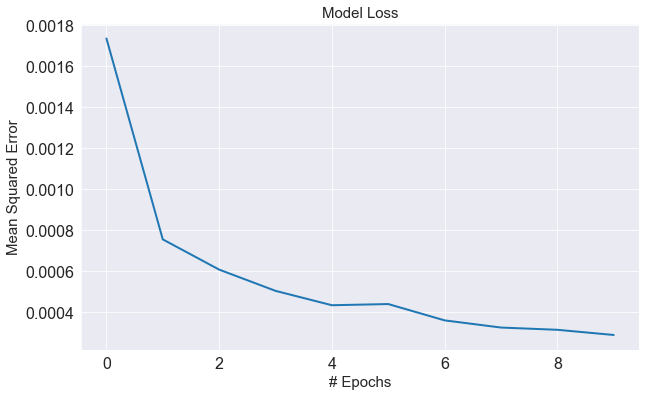

In [22]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], linewidth=2)
plt.title("Model Loss", fontsize=15)
plt.xlabel("# Epochs", fontsize=15)
plt.ylabel("Mean Squared Error", fontsize=15)

In [25]:
X_train_forecast = scaler.inverse_transform(model.predict(X_train))
y_train = scaler.inverse_transform([y_train.ravel()])

X_test_forecast = scaler.inverse_transform(model.predict(X_test))
y_test = scaler.inverse_transform([y_test.ravel()])

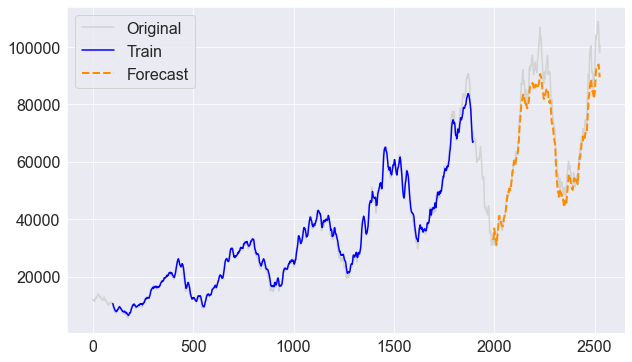

In [26]:
plt.figure(figsize=(10,6))

# Plot original dataset:
plt.plot(list(range(0, len(ds))), scaler.inverse_transform(ds), label="Original", color="lightgrey")

# Plot training data:
train_y_plot = X_train_forecast
train_x_plot = [i+lookback for i in list(range(0, len(X_train_forecast)))]
plt.plot(train_x_plot, train_y_plot , label="Train", color="blue")

# Plot forecasted data:
test_y_plot = X_test_forecast
test_x_plot = [i+lookback*2 for i in list(range(len(X_train_forecast), len(X_train_forecast)+len(X_test_forecast)))]
plt.plot(test_x_plot, test_y_plot , label="Forecast", color="darkorange", linewidth=2, linestyle="--")

plt.legend()